In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Ploting Functions

In [86]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  # still need to change this  
  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

# Data preprocessing

In [33]:
df_pre = pd.read_csv("data/formatted_medical7_aug5.csv",header=0, sep="\,")
selected_features = np.load("f4.npy")
# drop first columns as they are redundant 
df_pre.drop('Unnamed: 0', axis = 1, inplace = True)

#keep only selected columns
target ="Graft loss 1 year"
df_pre = df_pre[[target] + list(selected_features)]

discrete_columns = [
    'AB and Dr mismatch',
    'AKI - KDIGO 2012',
    'Acute RRT initiation',
    'Another urosepsis 1 year',
    'Charlston Comorbidity Index',
    'Donor',
    'FSGS',
    'GCS',
    'Induction',
    'Next UTI - 6 months',
    'Reduction 3--> 2',
    'Reduction to steroid only',
    'Steroid bolus',
    'Transfusion [YES/NO]',
    'Tripple maintenance therapy before admission',
    'Urinary sepsis'
]


feature_map = {}
rev_map = {}
i = 1
for col in df_pre.columns:
    if col == target:
        feature_map[col] = "target"
        rev_map["target"] = col
    else:
        feature_map[col] = "f"+ str(i)
        rev_map["f"+ str(i)] = col
        i = i+1
        
dis_col_maped = [feature_map[col] for col in discrete_columns]
df_pre = df_pre.rename(columns=feature_map)



#show impalanced in the dataset
neg, pos = np.bincount(df_pre["target"])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

#convert 64 types to 32
for k, v in zip(list(df_pre.columns), list(df_pre.dtypes)):
    if(v== np.float64):
        df_pre[k] = df_pre[k].astype('float32')
    if(v==np.int64):
        df_pre[k] = df_pre[k].astype('int32')
        
#fill_zero_by_mean('CIT [min]')
# convert int columne with two distincts to boolean 
#df_pre['Another urosepsis 1 year'] = df_pre['Another urosepsis 1 year'].astype('bool')
#df_pre['Next UTI - 6 months'] = df_pre['Next UTI - 6 months'].astype('bool')

# convert float target columne with two distincts to boolean 
df_pre["target"] = df_pre["target"].astype('int32')
for col in dis_col_maped:
    df_pre[col] = df_pre[col].astype('int32')

<ipython-input-33-31300289f0c9>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_pre = pd.read_csv("data/formatted_medical7_aug5.csv",header=0, sep="\,")


Examples:
    Total: 6894
    Positive: 649 (9.41% of total)



In [68]:
BATCH_SIZE = 64

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df_pre, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_ds = df_to_dataset(train_df, True, BATCH_SIZE)
test_ds = df_to_dataset(test_df, True, BATCH_SIZE)
val_ds = df_to_dataset(val_df, True, BATCH_SIZE)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('target'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('target'))
test_labels = np.array(test_df.pop('target'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)

#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4412,)
Validation labels shape: (1103,)
Test labels shape: (1379,)
Training features shape: (4412, 26)
Validation features shape: (1103, 26)
Test features shape: (1379, 26)


# Oversampeled Dataset

In [37]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [38]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

196.0

In [39]:
resample_df = np.zeros(shape = (resampled_features.shape[0]+1,resampled_features.shape[1]+1))
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
i = 0
for x, y in zip(resampled_features, resampled_labels): #zip(neg_ds.concatenate(pos_ds), np.arange(resampled_features.shape[0])):
    resample_df[i,0] = y
    resample_df[i, 1:] = x
    i= i+1

resample_df = pd.DataFrame(data=resample_df, columns=list(feature_map.values()))

In [40]:
resample_df

,target,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26
0,1.0,4.0,0.0,0.0,3.676648,0.0,1941.341309,141.413452,2.0,4.501289,...,201.565796,4.843758,0.0,1.0,0.0,0.0,1.0,0.0,73.203178,5.086738
1,1.0,4.0,0.0,0.0,2.279674,0.0,716.212524,297.537903,2.0,4.203562,...,284.502533,2.924456,0.0,0.0,1.0,0.0,1.0,0.0,69.866669,98.263084
2,1.0,1.0,1.0,0.0,1.599239,0.0,1231.393066,351.691589,2.0,4.505212,...,336.231567,3.091904,0.0,0.0,1.0,0.0,1.0,1.0,71.481499,5.788926
3,1.0,3.0,0.0,0.0,5.046967,0.0,1958.234863,376.724091,2.0,4.735485,...,199.138702,5.416481,0.0,0.0,0.0,0.0,1.0,0.0,84.205986,4.590648
4,1.0,3.0,0.0,0.0,3.197737,0.0,1822.997192,393.051727,9.0,4.850175,...,314.384827,4.397521,0.0,1.0,0.0,1.0,0.0,0.0,63.344669,6.643522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8012,0.0,2.0,1.0,0.0,3.537813,0.0,1735.010986,341.722961,4.0,0.921493,...,291.071777,3.142651,0.0,0.0,1.0,0.0,1.0,0.0,63.966076,3.402939
8013,0.0,4.0,1.0,0.0,3.214941,0.0,1431.843262,437.169098,6.0,3.573332,...,352.622986,2.694727,0.0,0.0,1.0,0.0,1.0,0.0,55.209583,2.166511
8014,0.0,1.0,1.0,0.0,3.747328,0.0,2128.132324,135.953217,5.0,1.374141,...,157.712418,3.305244,0.0,1.0,0.0,0.0,1.0,0.0,39.868248,3.851891
8015,0.0,5.0,0.0,0.0,3.193478,0.0,2521.020020,348.650177,2.0,4.897022,...,211.304855,2.706886,0.0,0.0,0.0,0.0,0.0,0.0,79.471397,0.150652


In [41]:
# Use a utility from sklearn to split and shuffle your dataset.
sampled_train_df, sampled_test_df = train_test_split(resample_df, test_size=0.2)
sampled_train_df, sampled_val_df = train_test_split(sampled_train_df, test_size=0.2)

sampled_train_ds = df_to_dataset(sampled_train_df, True, BATCH_SIZE)
sampled_test_ds = df_to_dataset(sampled_test_df, True, BATCH_SIZE)
sampled_val_ds = df_to_dataset(sampled_val_df, True, BATCH_SIZE)

# Form np arrays of labels and features.
sampled_train_labels = np.array(sampled_train_df.pop('target'))
sampled_bool_train_labels = train_labels != 0
sampled_val_labels = np.array(sampled_val_df.pop('target'))
sampled_test_labels = np.array(sampled_test_df.pop('target'))

# Model Initialization

In [43]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

all_inputs = []
encoded_features = []

# create input layer with categorical and numerical layers 
for header in df_pre.columns:
    # leave target as it is
    if header == "target":
        continue
    # encode discrete columns as one-hot vector
    elif header in dis_col_maped:
        discrete_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
        encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int32')
        encoded_discrete_col = encoding_layer(discrete_col)
        all_inputs.append(discrete_col)
        encoded_features.append(encoded_discrete_col)
    # normalize numeric columns (all with float32 type)
    else:    
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, train_ds)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)

In [116]:
EPOCHS = 100
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(64, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(8, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(x)

    model = tf.keras.Model(all_inputs, output)
    
    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model


# Model Exploit

### Baseline Model

In [64]:
model = make_model()
results = model.evaluate(train_ds, batch_size=BATCH_SIZE, verbose=0)
print("Initial Loss: {:0.4f}".format(results[0]))
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)
results = model.evaluate(train_ds, batch_size=BATCH_SIZE, verbose=0)
print("Tuned Loss: {:0.4f}".format(results[0]))

# save initial weight 
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Initial Loss: 1.1384
Tuned Loss: 0.3172


In [71]:
# zero bias at the outpur layer
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE, 
    epochs=20, 
    validation_data=val_ds, 
    verbose=0)

# crafter bias at the output layer
model = make_model(output_bias = initial_bias)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_ds, 
    verbose=0)

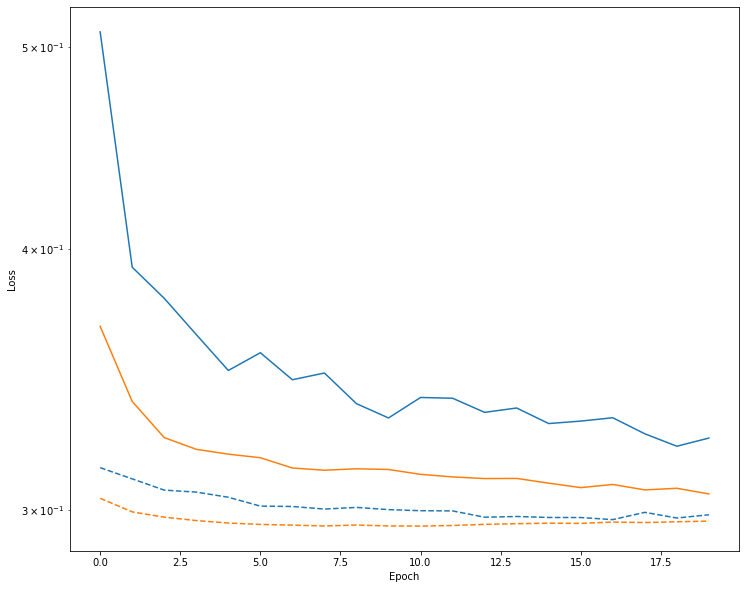

In [72]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [75]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
69/69 [==============================] - 4s 19ms/step - loss: 0.3595 - tp: 6.0000 - fp: 45.0000 - tn: 3945.0000 - fn: 416.0000 - accuracy: 0.8955 - precision: 0.1176 - recall: 0.0142 - auc: 0.5270 - prc: 0.1024 - val_loss: 0.3062 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4676 - val_prc: 0.0781
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3322 - tp: 0.0000e+00 - fp: 2.0000 - tn: 3988.0000 - fn: 422.0000 - accuracy: 0.9039 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5435 - prc: 0.1029 - val_loss: 0.2998 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4859 - val_prc: 0.0820
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3290 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 39

69/69 [==============================] - 0s 2ms/step - loss: 0.3077 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3990.0000 - fn: 422.0000 - accuracy: 0.9044 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6150 - prc: 0.1442 - val_loss: 0.2963 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4977 - val_prc: 0.0858
Epoch 20/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3072 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3990.0000 - fn: 422.0000 - accuracy: 0.9044 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6036 - prc: 0.1456 - val_loss: 0.2962 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4967 - val_prc: 0.0859
Epoch 21/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3056 - tp: 0.0000e+00 - fp: 0.0000e+00 

69/69 [==============================] - 0s 2ms/step - loss: 0.2981 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3989.0000 - fn: 422.0000 - accuracy: 0.9041 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6725 - prc: 0.1841 - val_loss: 0.2995 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5060 - val_prc: 0.0887
Epoch 38/100
69/69 [==============================] - 0s 2ms/step - loss: 0.2987 - tp: 1.0000 - fp: 0.0000e+00 - tn: 3990.0000 - fn: 421.0000 - accuracy: 0.9046 - precision: 1.0000 - recall: 0.0024 - auc: 0.6718 - prc: 0.1798 - val_loss: 0.3003 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5123 - val_prc: 0.0890
Epoch 39/100
69/69 [==============================] - 0s 2ms/step - loss: 0.2993 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3990.0000 

Epoch 56/100
69/69 [==============================] - 0s 2ms/step - loss: 0.2921 - tp: 2.0000 - fp: 1.0000 - tn: 3989.0000 - fn: 420.0000 - accuracy: 0.9046 - precision: 0.6667 - recall: 0.0047 - auc: 0.6935 - prc: 0.2083 - val_loss: 0.3018 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5214 - val_prc: 0.0906
Epoch 57/100
69/69 [==============================] - ETA: 0s - loss: 0.2956 - tp: 1.0000 - fp: 1.0000 - tn: 3989.0000 - fn: 421.0000 - accuracy: 0.9044 - precision: 0.5000 - recall: 0.0024 - auc: 0.6782 - prc: 0.1816           - 0s 2ms/step - loss: 0.2956 - tp: 1.0000 - fp: 1.0000 - tn: 3989.0000 - fn: 421.0000 - accuracy: 0.9044 - precision: 0.5000 - recall: 0.0024 - auc: 0.6782 - prc: 0.1816 - val_loss: 0.3028 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.000

69/69 [==============================] - 0s 2ms/step - loss: 0.2910 - tp: 6.0000 - fp: 6.0000 - tn: 3984.0000 - fn: 416.0000 - accuracy: 0.9044 - precision: 0.5000 - recall: 0.0142 - auc: 0.6840 - prc: 0.2188 - val_loss: 0.3037 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5273 - val_prc: 0.0905
Epoch 75/100
69/69 [==============================] - 0s 2ms/step - loss: 0.2870 - tp: 9.0000 - fp: 3.0000 - tn: 3987.0000 - fn: 413.0000 - accuracy: 0.9057 - precision: 0.7500 - recall: 0.0213 - auc: 0.7029 - prc: 0.2362 - val_loss: 0.3039 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1008.0000 - val_fn: 95.0000 - val_accuracy: 0.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5355 - val_prc: 0.0925
Epoch 76/100
69/69 [==============================] - 0s 2ms/step - loss: 0.2867 - tp: 10.0000 - fp: 3.0000 - tn: 3987.0000 - fn: 412.0000 - accura

### Baseline Model Evaluation

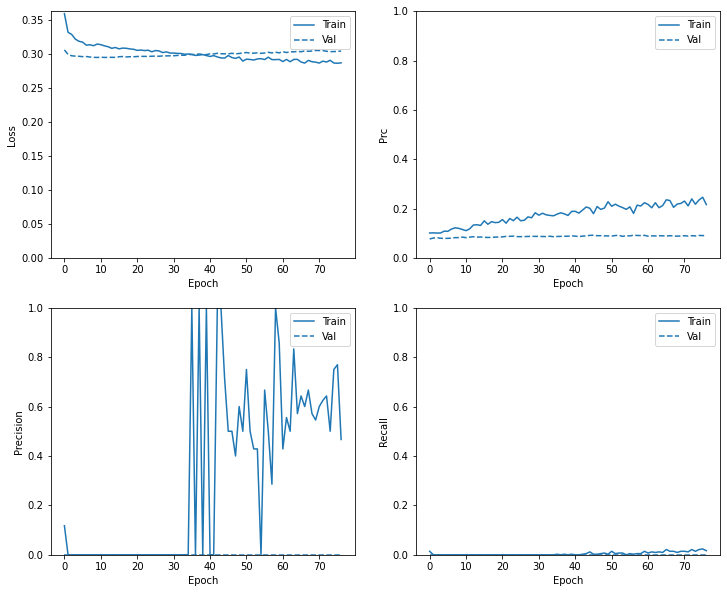

In [77]:
plot_metrics(baseline_history)

loss :  0.3299889862537384
tp :  0.0
fp :  0.0
tn :  1247.0
fn :  132.0
accuracy :  0.9042784571647644
precision :  0.0
recall :  0.0
auc :  0.5090337991714478
prc :  0.09955745935440063

Legitimate Transactions Detected (True Negatives):  1247
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  132
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  132


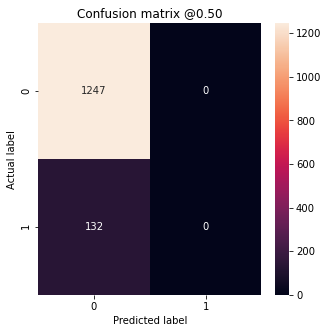

In [80]:
train_predictions_baseline = model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_ds, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(test_ds,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

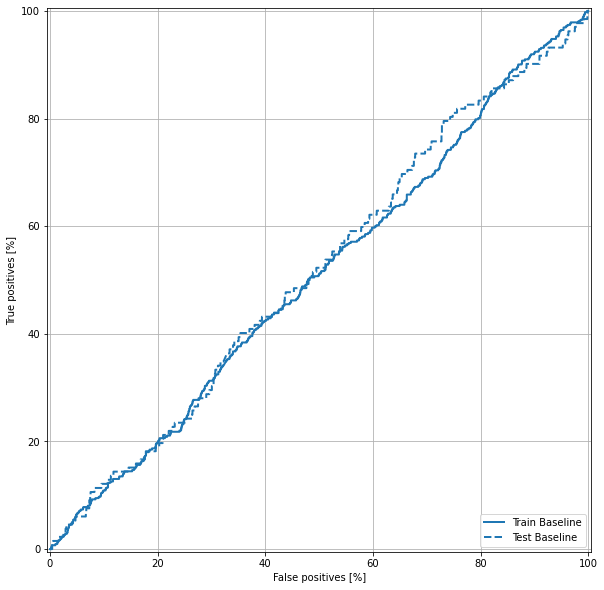

In [85]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

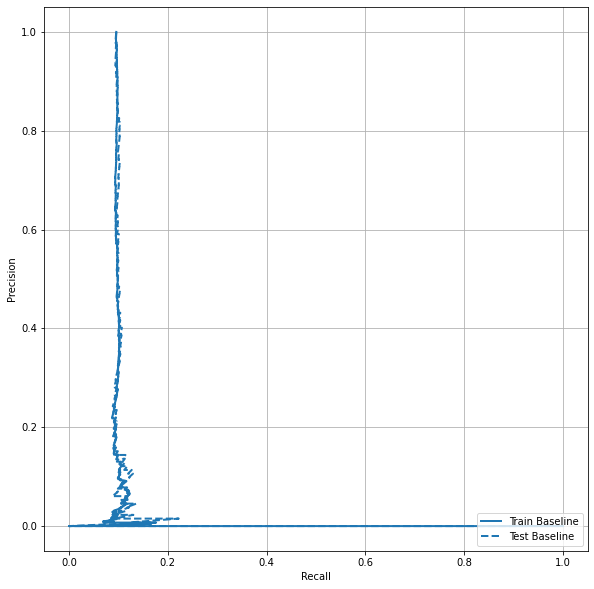

In [87]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

### Class Weighted Model

In [89]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds,
    # The class weights go here
    class_weight=class_weight)

Weight for class 0: 0.55
Weight for class 1: 5.31
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/100
69/69 [==============================] - 4s 19ms/step - loss: 1.1117 - tp: 75.0000 - fp: 917.0000 - tn: 4320.0000 - fn: 479.0000 - accuracy: 0.7589 - precision: 0.0756 - recall: 0.1354 - auc: 0.4724 - prc: 0.0873 - val_loss: 0.5203 - val_tp: 10.0000 - val_fp: 104.0000 - val_tn: 904.0000 - val_fn: 85.0000 - val_accuracy: 0.8286 - val_precision: 0.0877 - val_recall: 0.1053 - val_auc: 0.4694 - val_prc: 0.0816
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 0.9146 - tp: 136.0000 - fp: 1402.0000 - tn: 2588.0000 - fn: 286.0000 - accuracy: 0.6174 - precision: 0.0884 - recall: 0.3223 - auc: 0.4807 - prc: 0.0983 - val_loss: 0.5567 - val_tp: 13.0000 - val_fp: 129.0000 - val_tn: 879.0000 - val_fn: 82.0000 - val_accuracy: 0.8087 - val_precision: 0.0915 - val_recall: 0.1368 - val_auc: 0.4746 - val_prc: 0.0839
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 0.8671 - tp: 147.0000 - fp: 1341.0000 - tn: 2649.0000 - fn: 275.0000 - accuracy: 0

Epoch 20/100
69/69 [==============================] - 0s 2ms/step - loss: 0.7381 - tp: 168.0000 - fp: 1366.0000 - tn: 2624.0000 - fn: 254.0000 - accuracy: 0.6328 - precision: 0.1095 - recall: 0.3981 - auc: 0.5461 - prc: 0.1087 - val_loss: 0.6220 - val_tp: 27.0000 - val_fp: 247.0000 - val_tn: 761.0000 - val_fn: 68.0000 - val_accuracy: 0.7144 - val_precision: 0.0985 - val_recall: 0.2842 - val_auc: 0.4944 - val_prc: 0.1001
Epoch 21/100
69/69 [==============================] - 0s 2ms/step - loss: 0.7363 - tp: 172.0000 - fp: 1400.0000 - tn: 2590.0000 - fn: 250.0000 - accuracy: 0.6260 - precision: 0.1094 - recall: 0.4076 - auc: 0.5440 - prc: 0.1084 - val_loss: 0.6054 - val_tp: 23.0000 - val_fp: 196.0000 - val_tn: 812.0000 - val_fn: 72.0000 - val_accuracy: 0.7570 - val_precision: 0.1050 - val_recall: 0.2421 - val_auc: 0.4939 - val_prc: 0.1007
Epoch 22/100
69/69 [==============================] - 0s 2ms/step - loss: 0.7259 - tp: 179.0000 - fp: 1405.0000 - tn: 2585.0000 - fn: 243.0000 - accurac

### Weighted Class Model Evaluation

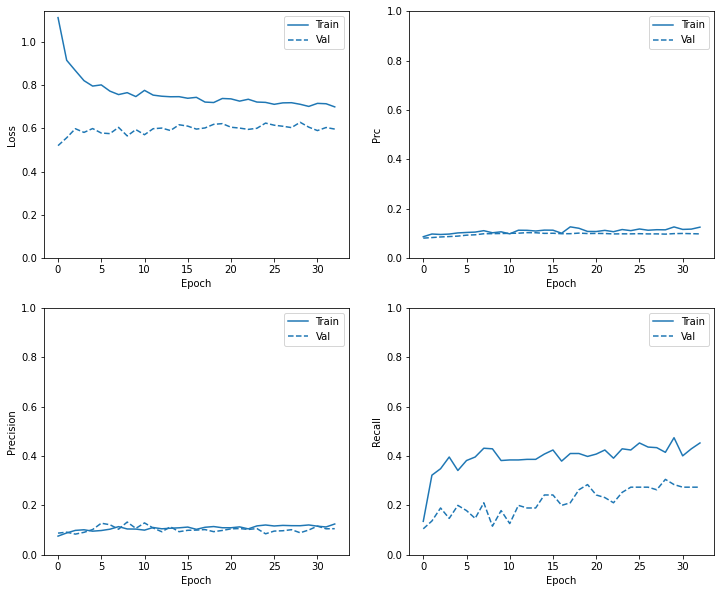

In [90]:
plot_metrics(weighted_history)


loss :  0.6040599942207336
tp :  25.0
fp :  202.0
tn :  1045.0
fn :  107.0
accuracy :  0.775924563407898
precision :  0.11013215780258179
recall :  0.18939393758773804
auc :  0.5218949913978577
prc :  0.10386863350868225

Legitimate Transactions Detected (True Negatives):  1041
Legitimate Transactions Incorrectly Detected (False Positives):  206
Fraudulent Transactions Missed (False Negatives):  111
Fraudulent Transactions Detected (True Positives):  21
Total Fraudulent Transactions:  132


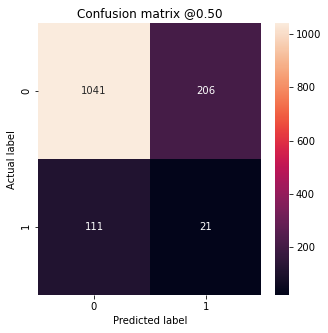

In [92]:
train_predictions_weighted = weighted_model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_ds, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_ds,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

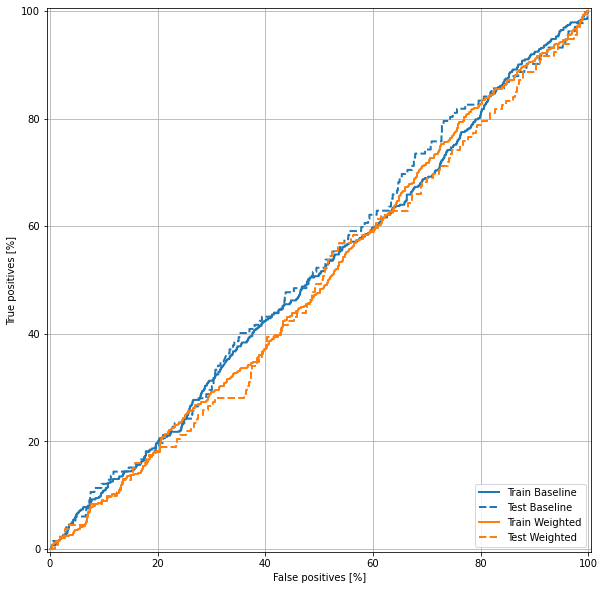

In [93]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

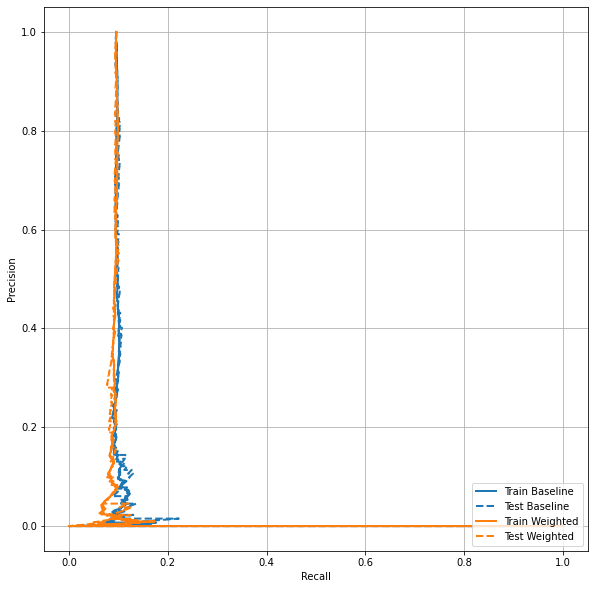

In [94]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

### Oversampled over minority class model

In [117]:
resampled_model = make_model()
#resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    sampled_train_ds,
    epochs=EPOCHS,
    #steps_per_epoch=20, #resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=sampled_val_ds)

\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
81/81 [==============================] - 4s 16ms/step - loss: 0.7235 - tp: 1343.0000 - fp: 1214.0000 - tn: 1290.0000 - fn: 1283.0000 - accuracy: 0.5133 - precision: 0.5252 - recall: 0.5114 - auc: 0.5185 - prc: 0.5200 - val_loss: 0.6977 - val_tp: 327.0000 - val_fp: 344.0000 - val_tn: 342.0000 - val_fn: 270.0000 - val_accuracy: 0.5214 - val_precision: 0.4873 - val_recall: 0.5477 - val_auc: 0.5164 - val_prc: 0.4658
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6997 - tp: 1145.0000 - fp: 979.0000 - tn: 1525.0000 - fn: 1481.0000 - accuracy: 0.5205 - precision: 0.5391 - recall: 0.4360 - auc: 0.5321 - prc: 0.5335 - val_loss: 0.6908 - val_tp: 331.0000 - val_fp: 326.0000 - val_tn: 360.0000 - val_fn: 266.0000 - val_accuracy: 0.5386 - val_precision: 0.5038 - val_recall: 0.5544 - val_auc: 0.5446 - val_prc: 0.4826
Epoch 3/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6883 - tp: 1401.0000 - fp: 1200.0000 - tn: 1304.0000 - fn: 1225.0000 - 

Epoch 20/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6514 - tp: 2087.0000 - fp: 1530.0000 - tn: 974.0000 - fn: 539.0000 - accuracy: 0.5967 - precision: 0.5770 - recall: 0.7947 - auc: 0.6410 - prc: 0.6492 - val_loss: 0.6500 - val_tp: 441.0000 - val_fp: 322.0000 - val_tn: 364.0000 - val_fn: 156.0000 - val_accuracy: 0.6274 - val_precision: 0.5780 - val_recall: 0.7387 - val_auc: 0.6891 - val_prc: 0.6232
Epoch 21/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6472 - tp: 2075.0000 - fp: 1452.0000 - tn: 1052.0000 - fn: 551.0000 - accuracy: 0.6096 - precision: 0.5883 - recall: 0.7902 - auc: 0.6557 - prc: 0.6609 - val_loss: 0.6462 - val_tp: 412.0000 - val_fp: 300.0000 - val_tn: 386.0000 - val_fn: 185.0000 - val_accuracy: 0.6220 - val_precision: 0.5787 - val_recall: 0.6901 - val_auc: 0.6905 - val_prc: 0.6232
Epoch 22/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6484 - tp: 2125.0000 - fp: 1536.0000 - tn: 968.0000 - fn: 501.0000 - ac

81/81 [==============================] - 0s 2ms/step - loss: 0.6305 - tp: 2214.0000 - fp: 1548.0000 - tn: 956.0000 - fn: 412.0000 - accuracy: 0.6179 - precision: 0.5885 - recall: 0.8431 - auc: 0.6686 - prc: 0.6691 - val_loss: 0.6242 - val_tp: 467.0000 - val_fp: 317.0000 - val_tn: 369.0000 - val_fn: 130.0000 - val_accuracy: 0.6516 - val_precision: 0.5957 - val_recall: 0.7822 - val_auc: 0.7165 - val_prc: 0.6425
Epoch 40/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6273 - tp: 2242.0000 - fp: 1613.0000 - tn: 891.0000 - fn: 384.0000 - accuracy: 0.6107 - precision: 0.5816 - recall: 0.8538 - auc: 0.6681 - prc: 0.6782 - val_loss: 0.6241 - val_tp: 473.0000 - val_fp: 322.0000 - val_tn: 364.0000 - val_fn: 124.0000 - val_accuracy: 0.6524 - val_precision: 0.5950 - val_recall: 0.7923 - val_auc: 0.7192 - val_prc: 0.6422
Epoch 41/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6232 - tp: 2215.0000 - fp: 1532.0000 - tn: 972.0000 - fn: 411.0000 - accuracy: 0.6212

81/81 [==============================] - 0s 2ms/step - loss: 0.6140 - tp: 2337.0000 - fp: 1651.0000 - tn: 853.0000 - fn: 289.0000 - accuracy: 0.6218 - precision: 0.5860 - recall: 0.8899 - auc: 0.6840 - prc: 0.6920 - val_loss: 0.6038 - val_tp: 526.0000 - val_fp: 322.0000 - val_tn: 364.0000 - val_fn: 71.0000 - val_accuracy: 0.6937 - val_precision: 0.6203 - val_recall: 0.8811 - val_auc: 0.7525 - val_prc: 0.6726
Epoch 59/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6176 - tp: 2335.0000 - fp: 1672.0000 - tn: 832.0000 - fn: 291.0000 - accuracy: 0.6173 - precision: 0.5827 - recall: 0.8892 - auc: 0.6752 - prc: 0.6829 - val_loss: 0.6049 - val_tp: 524.0000 - val_fp: 341.0000 - val_tn: 345.0000 - val_fn: 73.0000 - val_accuracy: 0.6773 - val_precision: 0.6058 - val_recall: 0.8777 - val_auc: 0.7526 - val_prc: 0.6736
Epoch 60/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6210 - tp: 2326.0000 - fp: 1678.0000 - tn: 826.0000 - fn: 300.0000 - accuracy: 0.6144 -

81/81 [==============================] - 0s 2ms/step - loss: 0.6087 - tp: 2414.0000 - fp: 1712.0000 - tn: 792.0000 - fn: 212.0000 - accuracy: 0.6250 - precision: 0.5851 - recall: 0.9193 - auc: 0.6892 - prc: 0.6948 - val_loss: 0.5907 - val_tp: 515.0000 - val_fp: 343.0000 - val_tn: 343.0000 - val_fn: 82.0000 - val_accuracy: 0.6687 - val_precision: 0.6002 - val_recall: 0.8626 - val_auc: 0.7541 - val_prc: 0.6772
Epoch 78/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6083 - tp: 2410.0000 - fp: 1712.0000 - tn: 792.0000 - fn: 216.0000 - accuracy: 0.6242 - precision: 0.5847 - recall: 0.9177 - auc: 0.6839 - prc: 0.6924 - val_loss: 0.5925 - val_tp: 540.0000 - val_fp: 360.0000 - val_tn: 326.0000 - val_fn: 57.0000 - val_accuracy: 0.6750 - val_precision: 0.6000 - val_recall: 0.9045 - val_auc: 0.7550 - val_prc: 0.6807
Epoch 79/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6001 - tp: 2409.0000 - fp: 1697.0000 - tn: 807.0000 - fn: 217.0000 - accuracy: 0.6269 -

### Oversampled Model Evaluation

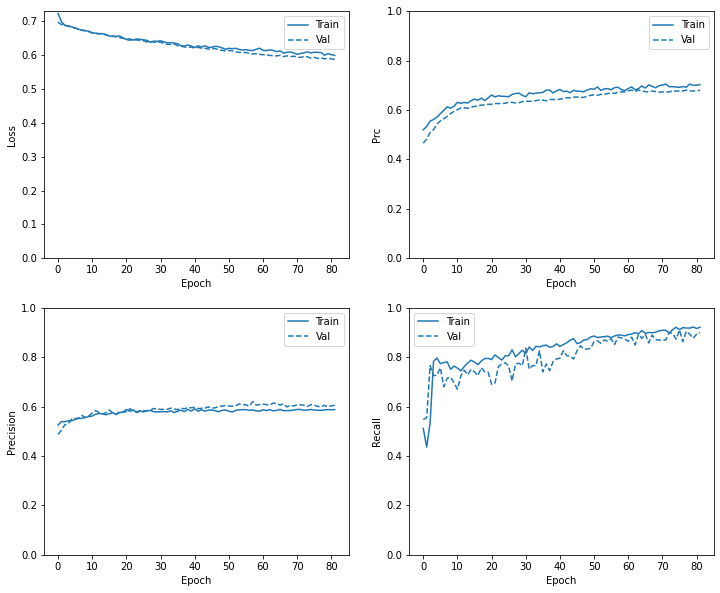

In [118]:
plot_metrics(resampled_history)

loss :  0.6024455428123474
tp :  685.0
fp :  416.0
tn :  403.0
fn :  100.0
accuracy :  0.6783042550086975
precision :  0.6221616864204407
recall :  0.8726114630699158
auc :  0.7577098608016968
prc :  0.7125130295753479

Legitimate Transactions Detected (True Negatives):  253
Legitimate Transactions Incorrectly Detected (False Positives):  566
Fraudulent Transactions Missed (False Negatives):  250
Fraudulent Transactions Detected (True Positives):  535
Total Fraudulent Transactions:  785


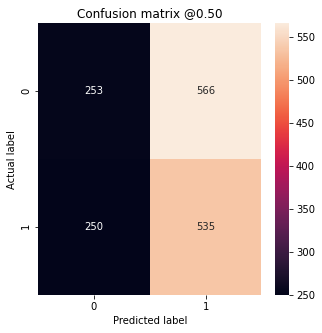

In [119]:
train_predictions_resampled = resampled_model.predict(sampled_train_ds, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(sampled_test_ds, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(sampled_test_ds,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(sampled_test_labels, test_predictions_resampled)

### Retrained Oversampled Model

In [120]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    sampled_train_ds,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=sampled_val_ds)

\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


ValueError: Shapes (8,) and (16,) are incompatible

### Retrained Oversampled Model Evaluation

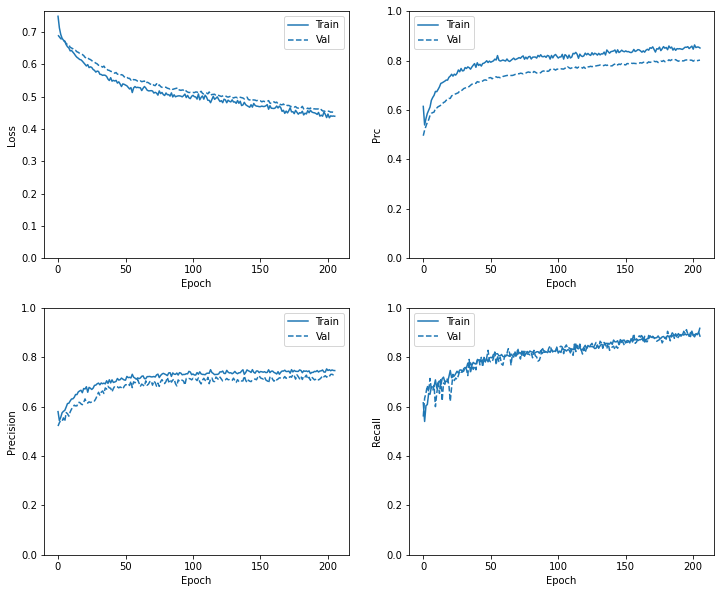

In [112]:
plot_metrics(resampled_history)

loss :  0.44219598174095154
tp :  711.0
fp :  251.0
tn :  568.0
fn :  74.0
accuracy :  0.7973815202713013
precision :  0.7390852570533752
recall :  0.9057325124740601
auc :  0.8796116709709167
prc :  0.8428502678871155

Legitimate Transactions Detected (True Negatives):  320
Legitimate Transactions Incorrectly Detected (False Positives):  499
Fraudulent Transactions Missed (False Negatives):  322
Fraudulent Transactions Detected (True Positives):  463
Total Fraudulent Transactions:  785


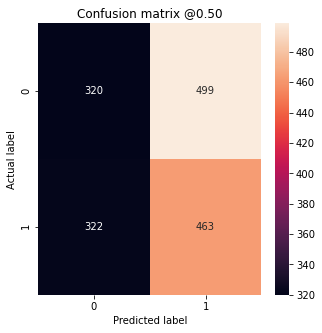

In [113]:
train_predictions_resampled = resampled_model.predict(sampled_train_ds, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(sampled_test_ds, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(sampled_test_ds,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(sampled_test_labels, test_predictions_resampled)

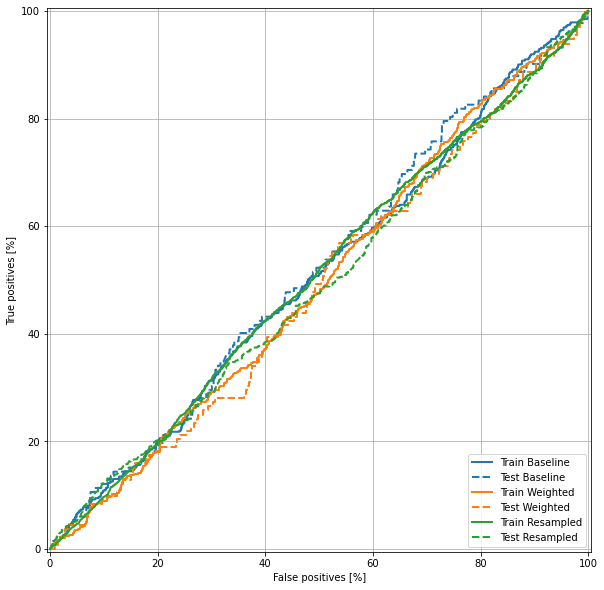

In [114]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", sampled_train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", sampled_test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

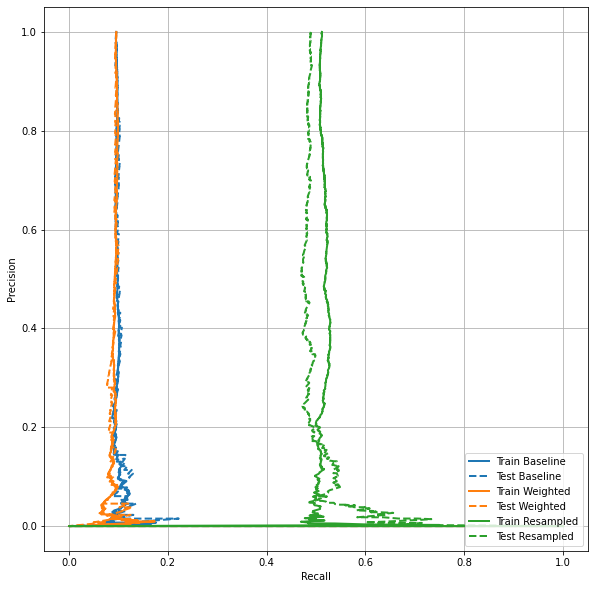

In [115]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", sampled_train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", sampled_test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')